In [146]:
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from collections import deque
from time import time

%matplotlib notebook


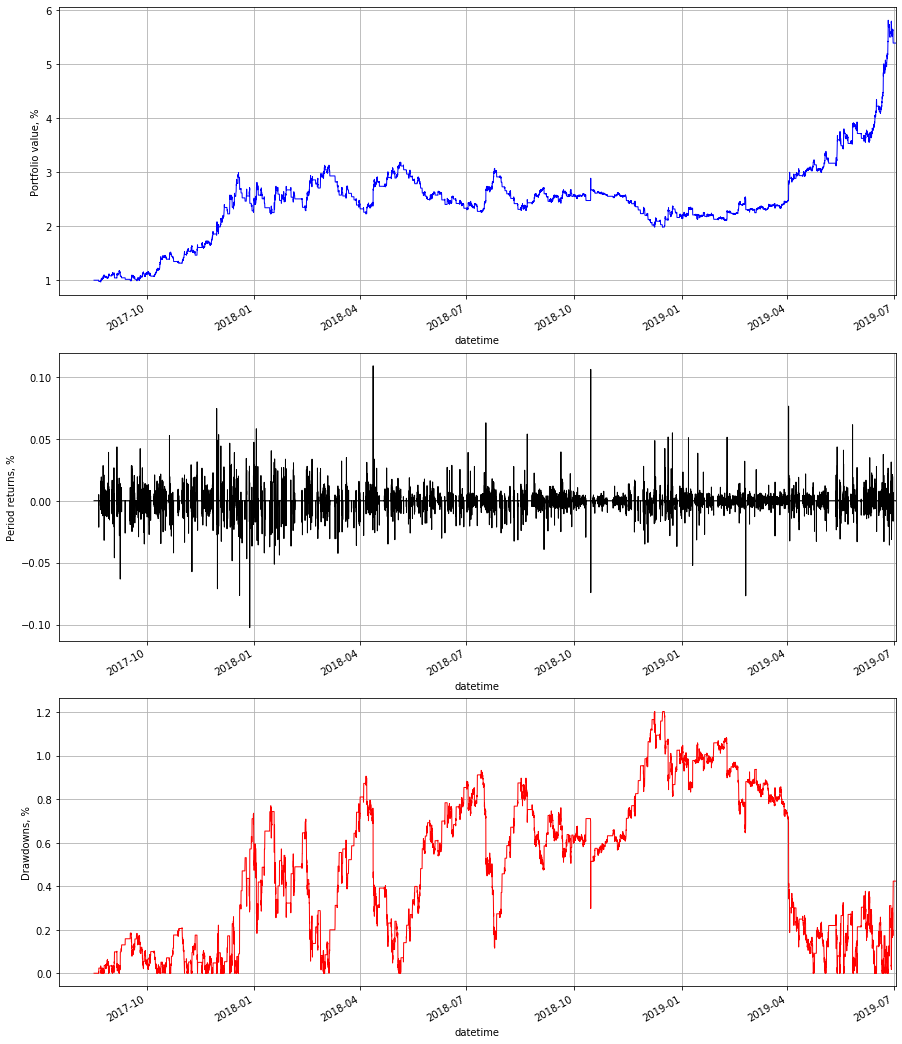

In [81]:
data = pd.read_csv('../equity.csv', header=0, parse_dates=True, index_col=0)
data = data.sort_index()

fig = plt.figure(figsize=[15, 20])
fig.patch.set_facecolor('white')

ax1 = fig.add_subplot(311, ylabel='Portfolio value, %')
data['equity_curve'].plot(ax=ax1, color="blue", lw=1.)
plt.grid(True)

ax2 = fig.add_subplot(312, ylabel='Period returns, %')
data['returns'].plot(ax=ax2, color="black", lw=1.)
plt.grid(True)

ax3 = fig.add_subplot(313, ylabel='Drawdowns, %')
data['drawdown'].plot(ax=ax3, color="red", lw=1.)
plt.grid(True)

plt.show()

DatetimeIndex(['2017-07-18 00:00:00', '2017-08-17 04:00:00',
               '2017-08-17 05:00:00', '2017-08-17 06:00:00',
               '2017-08-17 07:00:00', '2017-08-17 08:00:00',
               '2017-08-17 09:00:00', '2017-08-17 10:00:00',
               '2017-08-17 11:00:00', '2017-08-17 12:00:00',
               ...
               '2019-07-02 07:00:00', '2019-07-02 08:00:00',
               '2019-07-02 09:00:00', '2019-07-02 10:00:00',
               '2019-07-02 11:00:00', '2019-07-02 12:00:00',
               '2019-07-02 13:00:00', '2019-07-02 14:00:00',
               '2019-07-02 15:00:00', '2019-07-02 15:00:00'],
              dtype='datetime64[ns]', name='datetime', length=16346, freq=None)

In [147]:
trades = pd.read_csv('../trades.csv', header=0, parse_dates=True, index_col=0)

In [148]:
columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
data = pd.read_csv('../exchange_data/BTC-USDT_1h.csv', header=None, index_col=0, names=columns)

In [149]:
data.index = pd.to_datetime(data.index, unit='ms')
data = data.drop_duplicates()

<IPython.core.display.Javascript object>


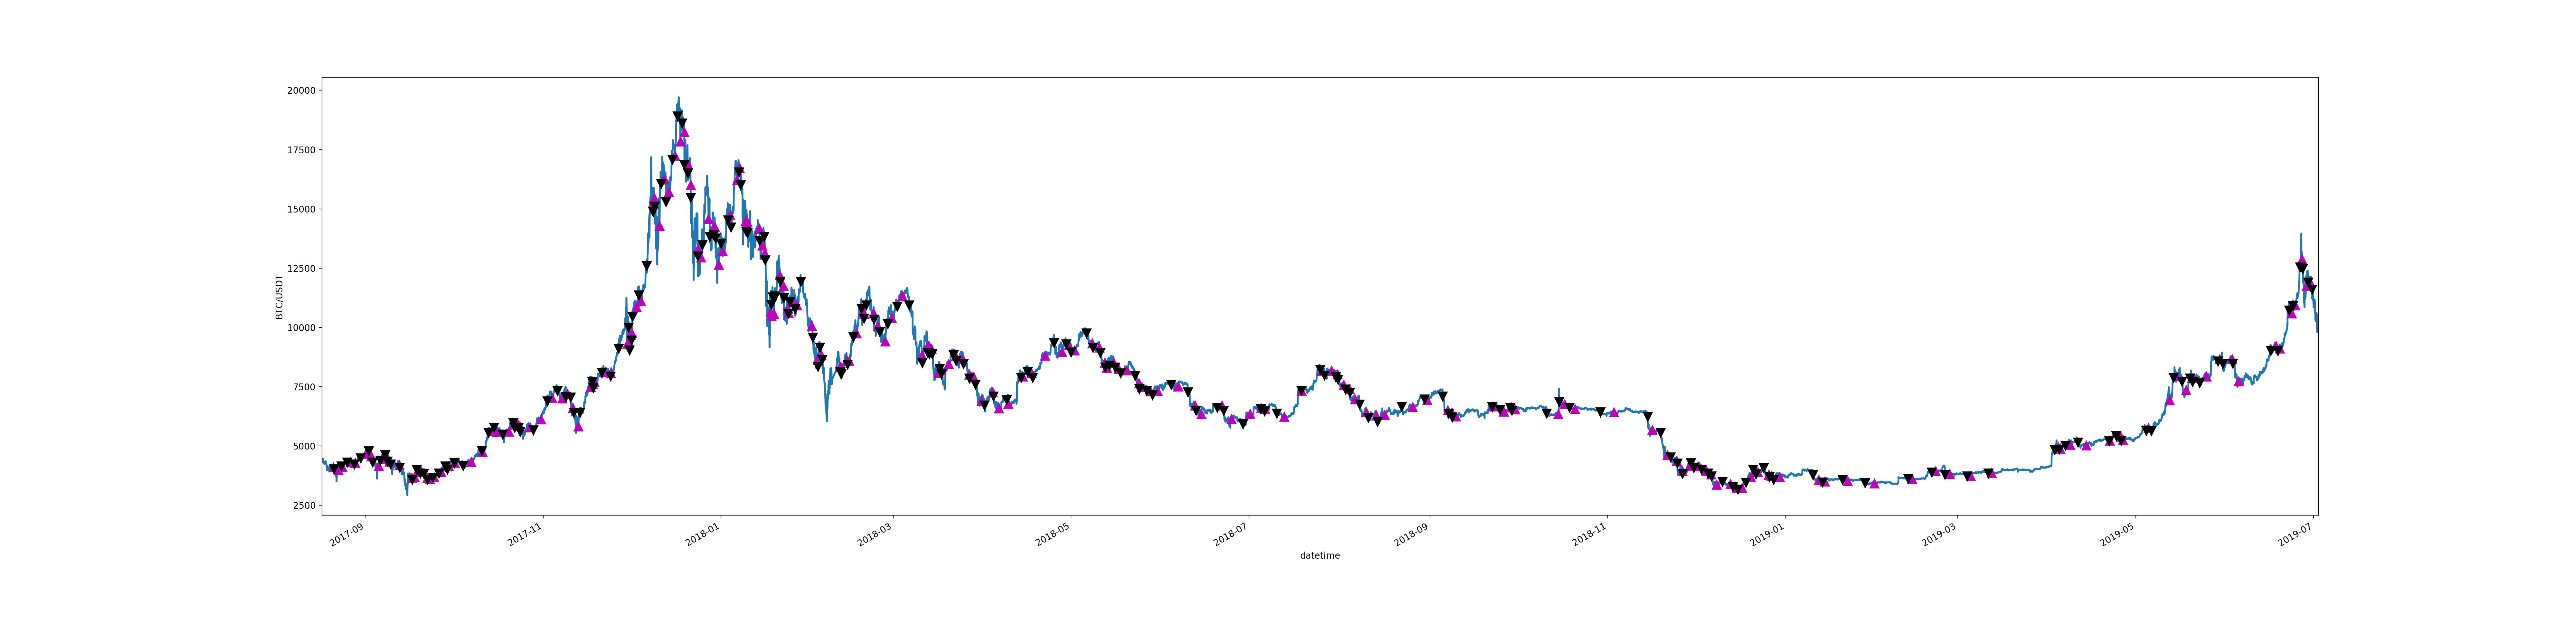

In [150]:
trades['open_date'] = pd.to_datetime(trades['open_date'])
trades['close_date'] = pd.to_datetime(trades['close_date'])
fig = plt.figure(figsize=(40, 10))
ax1 = fig.add_subplot(111, ylabel='BTC/USDT')
data['close'].plot(ax=ax1, lw=2.)
ax1.plot(trades['open_date'], trades['open_market_price'], '^', markersize=10, color='m')
ax1.plot(trades['close_date'], trades['close_market_price'], 'v', markersize=10, color='k')

In [120]:
trades

,symbol,is_open,open_price,open_date,close_price,close_date,duration,returns,win_trades,loss_trades
0,BTC-USDT,False,100.000000,2017-08-21 00:00:00,97.775711,2017-08-21 05:00:00.000,0 days 05:00:00.000000000,-0.022243,False,True
1,BTC-USDT,False,97.627380,2017-08-22 19:00:00,101.526604,2017-08-23 18:00:00.000,0 days 23:00:00.000000000,0.039940,True,False
2,BTC-USDT,False,101.377238,2017-08-24 03:00:00,106.148173,2017-08-25 19:00:00.000,1 days 16:00:00.000000000,0.047061,True,False
3,BTC-USDT,False,105.992529,2017-08-26 21:00:00,103.855469,2017-08-28 04:00:00.000,1 days 07:00:00.000000000,-0.020162,False,True
4,BTC-USDT,False,103.698083,2017-08-28 14:00:00,108.310587,2017-08-30 09:00:00.000,1 days 19:00:00.000000000,0.044480,True,False
5,BTC-USDT,False,108.151581,2017-09-01 04:00:00,110.838472,2017-09-02 03:00:00.000,0 days 23:00:00.000000000,0.024844,True,False
6,BTC-USDT,False,110.674229,2017-09-03 01:00:00,104.439095,2017-09-03 13:00:00.000,0 days 12:00:00.000000000,-0.056338,False,True
7,BTC-USDT,False,104.277760,2017-09-05 15:00:00,110.243523,2017-09-06 04:00:00.000,0 days 13:00:00.000000000,0.057210,True,False
8,BTC-USDT,False,110.082632,2017-09-07 01:00:00,114.210784,2017-09-07 20:00:00.000,0 days 19:00:00.000000000,0.037500,True,False
9,BTC-USDT,False,114.042564,2017-09-08 03:00:00,107.801866,2017-09-08 13:00:00.000,0 days 10:00:00.000000000,-0.054723,False,True


In [111]:
trades['open_date']

0      2017-08-21 00:00:00.000
1      2017-08-22 19:00:00.000
2      2017-08-24 03:00:00.000
3      2017-08-26 21:00:00.000
4      2017-08-28 14:00:00.000
                ...           
210    2019-06-23 10:00:00.000
211    2019-06-24 15:00:00.000
212    2019-06-27 01:00:00.000
213    2019-06-28 12:00:00.000
214    2019-06-29 15:00:00.000
Name: open_date, Length: 215, dtype: object

In [151]:
def crossed(series1, series2, direction=None):
    if isinstance(series1, np.ndarray):
        series1 = pd.Series(series1)

    if isinstance(series2, (float, int, np.ndarray)):
        series2 = pd.Series(index=series1.index, data=series2)

    if direction is None or direction == "above":
        above = pd.Series((series1 > series2) & (
            series1.shift(1) <= series2.shift(1)))

    if direction is None or direction == "below":
        below = pd.Series((series1 < series2) & (
            series1.shift(1) >= series2.shift(1)))

    if direction is None:
        return above or below

    return above if direction == "above" else below


def crossed_above(series1, series2):
    return crossed(series1, series2, "above")


def crossed_below(series1, series2):
    return crossed(series1, series2, "below")

In [173]:
rsi = np.array([14, 14, 40, 12, 21])
crossed_above(rsi, 20).iloc[-1]

True